In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [207]:
df = pd.read_csv('./data/latimes-place-totals.csv')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167270 entries, 0 to 167269
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             167270 non-null  object 
 1   county           167270 non-null  object 
 2   fips             165673 non-null  float64
 3   place            167270 non-null  object 
 4   confirmed_cases  167270 non-null  int64  
 5   note             5176 non-null    object 
 6   x                164796 non-null  float64
 7   y                164796 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 10.2+ MB


In [87]:
df[['x', 'y']].isna().sum()

x    2474
y    2474
dtype: int64

In [90]:
# drop these
df = df.dropna(subset = ['x', 'y'])
df[['x', 'y']].isna().sum()

x    0
y    0
dtype: int64

In [144]:
df_x_y

,x,y
0,-122.274444,37.756111
1,-122.297778,37.886944
2,-122.272778,37.871667
3,-121.935833,37.702222
4,-122.285278,37.831389


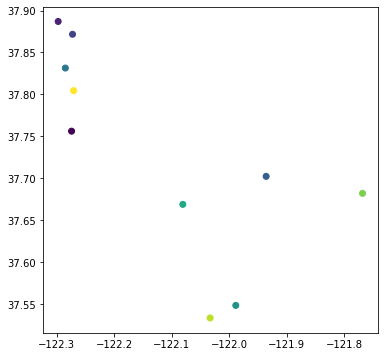

In [145]:
df_x_y = df[['x', 'y']][:10]
plt.figure(figsize=(6, 6));
plt.scatter(df_x_y['x'], df_x_y['y'], c = df_x_y.index)

### Is the target point within range?
- The 'range' is whatever is in the ellipse shown below, with the major axis representing the distance from your start and ending points
<center>
 <img src="./pics/Ellipse.png" alt="drawing" width="400"/>
</center>
- In this ellipse, the perimeter represents the points at which your path has the same length.
<center>
 <img src="./pics/p1_ellipse.png" alt="drawing" width="400"/>
 <img src="./pics/p2_ellipse.png" alt="drawing" width="400"/>
</center>

In [40]:
# given starting point, ending point, and target point
start_coords = (1, 5)
end_coords = (4, 2)
target_point = (1, 3)
max_length = 1.25

# NEED TO ROTATE THIS ELLIPSE
- where (xp, yp) are the point coordinates and (x0, y0) is the center of the ellipse
- where a is the minor axis and b is the major axis

<center>
 <img src="./pics/ellipse_eq.png" alt="drawing" width="800"/>
</center>

In [233]:
def in_ellipse(start, end, target, max_distance_increase):
    
    x_target = target[0]
    y_target = target[1]
    
    # midpoint on the line connecting the start and stop
    x_midpoint = (start[0] + end[0]) / 2
    y_midpoint = (start[1] + end[1]) / 2
    midpoint = (x_midpoint, y_midpoint)
    
    #change in x and y for the stop and start coords
    delta_x = end[0] - start[0]
    delta_y = end[1] - start[1]

    #distance between start and stop
    d = np.sqrt((delta_x)**2 + (delta_y)**2)
    
    #major and minor axis based on distance between two points and the max distance increase
    major_axis = d
    minor_axis = d * np.sqrt(max_distance_increase**2 - 1)

    #for the ellipse, we need the angle of the line (the line connecting start and stop points) and the x axis
    line_angle_radians = np.arctan(delta_y / delta_x)
    line_angle = np.degrees(line_angle_radians)
    
    #now for the ellipse equation:
    alpha = line_angle_radians
    #component 1:
    component_1 = ((np.cos(line_angle) * (x_target - x_midpoint)) + (np.sin(line_angle) * (y_target - y_midpoint)))**2 / (minor_axis ** 2)
    #component 2:
    component_2 = ((np.sin(line_angle) * (x_target - x_midpoint)) - (np.cos(line_angle) * (y_target - y_midpoint)))**2 / (major_axis ** 2)
    
    ellipse_eq = component_1 + component_2
    
    if ellipse_eq <= 1:
        return True
    else:
        return False

In [188]:
def in_ellipse_2(start, end, target, max_distance_increase):
    # create x and y designations
    x1 = start[0]
    y1 = start[1]
    x2 = end[0]
    y2 = end[1]
    x_target = target[0]
    y_target = target[1]

    # how long is this trip with no stops? (length of line)
    d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    # what is the midpoint between start and end points?
    x_midpoint = (x1 + x2) / 2
    y_midpoint = (y1 + y2) / 2
    m = (x_midpoint, y_midpoint)

    # how much longer are you willing to increase your trip?
    max_d = max_distance_increase * d
    
    # ellipse equation components:
    semi_major_axis = d/2
    semi_minor_axis = (d * np.sqrt(max_distance_increase**2 - 1))/2
    
    component_1 = (x_target - x_midpoint)**2 / semi_major_axis**2
    component_2 = (y_target - y_midpoint)**2 / semi_minor_axis**2
    
    # is the target point in this ellipse region?
    region_eq = component_1 + component_2
    
    if region_eq <= 1:
        return True
    else:
        return False

In [191]:
in_ellipse(start = start_coords, end = end_coords, target = target_point, max_distance_increase = max_length)

True

In [192]:
# If it's in the ellipse, how long is your journey?
def trip_length(start, end, target):
    # create x and y designations
    x1 = start[0]
    y1 = start[1]
    x2 = end[0]
    y2 = end[1]
    x_target = target[0]
    y_target = target[1]
    
    # distance from start to target
    start_target = np.sqrt((x1 - x_target)**2 + (y1 - y_target)**2)
    
    #distance from target to end
    target_end = np.sqrt((x2 - x_target)**2 + (y2 - y_target)**2)
    
    return start_target + target_end

In [193]:
trip_length(start = start_coords, end = end_coords, target = target_point)

5.16227766016838

In [194]:
# What's the ratio of your new journey vs if you hadn't stopped at all?
def trip_ratio(start, end, target):
    # distance without stop
    d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    #distance with stop
    new_journey = trip_length(start, end, target)
    
    return new_journey / d

In [195]:
trip_ratio(start = start_coords, end = end_coords, target = target_point)

1.2167605132909618

### Try with list of coordinates

In [196]:
x_list = [1, 2, 3]
y_list = [1, 2, 3]

coordinate_list = []
for x in range(len(x_list)):
    a, b = x_list[x], y_list[x]
    coordinate_list.append((a, b))
    
print(coordinate_list)

[(1, 1), (2, 2), (3, 3)]


In [197]:
for x in coordinate_list:
    if in_ellipse(start = start_coords, end = end_coords, target = x, max_distance_increase = 1.25) == True:
        print(trip_ratio(start = start_coords, end = end_coords, target = x))
    else:
        print('not in range')

1.6881650340819936
1.2167605132909618
1.0000000000000002


### Visualize this example

In [198]:
print((start_coords), (end_coords))

(1, 5) (4, 2)


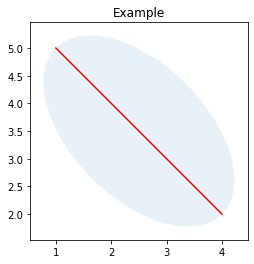

-45.0

In [199]:
def start_end_line(start, end):
    slope = (start[1] - end[1]) / (start[0] - end[0])
    b = start[1] - (slope * start[0])
    
    x = np.linspace(start[0], end[0])
    y = slope * x + b
    return (x, y)

start_end_line(start_coords, end_coords)

plt.plot(start_end_line(start_coords, end_coords)[0], start_end_line(start_coords, end_coords)[1], '-r')
plt.title('Example')

x_midpoint = (start_coords[0] + end_coords[0]) / 2
y_midpoint = (start_coords[1] + end_coords[1]) / 2
midpoint = (x_midpoint, y_midpoint)
midpoint

delta_x = end_coords[0] - start_coords[0]
delta_y = end_coords[1] - start_coords[1]

d = np.sqrt((delta_x)**2 + (delta_y)**2)

max_distance_increase = 1.15
h = semi_minor_axis = d * np.sqrt(max_distance_increase**2 - 1)

line_angle = np.degrees(np.arctan(delta_y / delta_x))

# Now for the ellipse plot
# https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html
ellipse = Ellipse(xy = midpoint, width = d, height = h, angle = line_angle, alpha = .1)
plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.show()

line_angle
#print(delta_x, delta_y)

In [106]:
from matplotlib.patches import Ellipse

### Function for dataframe of coordinates
- Given a dataframe of coordinates, determine if these are in the ellipse range of some start and stop point
    - Only keep the rows that are in range
- For this pruned dataframe, create two new columns:
    - Trip length
    - Trip ratio

In [223]:
def places_in_range_df(start, stop, max_distance_increase, coordinate_df):
    # assuming we have a clean df (no NaN values)
    
    # only keep x and y coordinate columns
    df = coordinate_df[['x', 'y', 'ordinal_cat']]
    
    # make these columns into lists
    x_list = df['x'].tolist()
    y_list = df['y'].tolist()
    
    # create list of coordinates as tuples
    coordinate_list = []
    for x in range(len(x_list)):
        a, b = x_list[x], y_list[x]
        coordinate_list.append((a, b))
    
    #create empty list that will be filled 'yes' if in range, and 'no' if not in range
    in_range = []
    #create empty list that will be filled with the trip ratio for the coordinates that are in range and NaN for not in range
    trip_ratios = []
    #create empty list that will be filled with the trip length for the coordinates that are in range and NaN for not in range
    trip_lengths = []
    
    #loop through coordinate list
    for x in coordinate_list:
        # for each row / coordiante, determine if it's in range
        if in_ellipse(start = start, end = stop, target = x, max_distance_increase = max_distance_increase) == True:
            in_range.append('yes')
            trip_ratios.append(trip_ratio(start = start, end = stop, target = x))
            trip_lengths.append(trip_length(start = start, end = stop, target = x))
        else:
            in_range.append('no')
            trip_ratios.append(None)
            trip_lengths.append(None)
        
    df['in_range'] = in_range
    df['trip_ratios'] = trip_ratios
    df['trip_lengths'] = trip_lengths
    return df

In [201]:
in_range_example_df = places_in_range_df(start = (-121.935833, 37.702222), stop = (-122.297778, 37.886944), max_distance_increase = 1.25, coordinate_df = df_x_y)

In [202]:
in_range_example_df.head()

,x,y,in_range,trip_ratios,trip_lengths
0,-122.274444,37.756111,yes,0.112140,0.475770
1,-122.297778,37.886944,yes,0.095779,0.406357
2,-122.272778,37.871667,yes,0.095801,0.406450
3,-121.935833,37.702222,yes,0.095779,0.406357
4,-122.285278,37.831389,yes,0.101233,0.429497


In [209]:
in_range_example_df['in_range'].unique().sum()

'yesno'

## Create Visualization function

In [234]:
def full_viz(start, stop, max_distance_increase, coordinate_df):
    # for visualizing the line connecting start and stop points
    (x, y) = start_end_line(start, stop)
    plt.plot(x, y, '-r')
    
    # midpoint on the line connecting the start and stop
    x_midpoint = (start[0] + stop[0]) / 2
    y_midpoint = (start[1] + stop[1]) / 2
    midpoint = (x_midpoint, y_midpoint)
    
    #change in x and y for the stop and start coords
    delta_x = stop[0] - start[0]
    delta_y = stop[1] - start[1]

    #distance between start and stop
    d = np.sqrt((delta_x)**2 + (delta_y)**2)
    
    #major and minor axis based on distance between two points and the max distance increase
    major_axis = d
    minor_axis = d * np.sqrt(max_distance_increase**2 - 1)

    #for plotting the ellipse, we need the angle of the line (the line connecting start and stop points) and the x axis
    line_angle = np.degrees(np.arctan(delta_y / delta_x))

    # Now for the ellipse plot
    # https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html
    ellipse = Ellipse(xy = midpoint, width = major_axis, height = minor_axis, angle = line_angle, alpha = .1)
    plt.gca().add_patch(ellipse)

    plt.axis('scaled')
    
    #Now for visualizing which points are in the ellipse
    df = places_in_range_df(start = start, stop = stop, max_distance_increase = max_distance_increase, coordinate_df = coordinate_df)
    #map the in_range column to be numeric
    df['in_range_numeric'] = df['in_range'].map({'yes': 1, 'no': 0})
    
    df_zero = df.loc[df['in_range_numeric'] == 0]
    df_ones = df.loc[df['in_range_numeric'] == 1]
    
    plt.xlim(-124, -114)
    plt.ylim(33, 42)
    plt.scatter(df_zero['x'], df_zero['y'], marker = 'o', c = df_zero['ordinal_cat'])
    plt.scatter(df_ones['x'], df_ones['y'], marker = "^", c = df_ones['ordinal_cat'])
    
    plt.show()

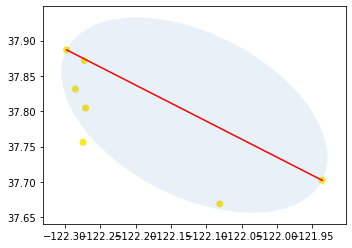

In [206]:
full_viz(start = (-121.935833, 37.702222), stop = (-122.297778, 37.886944), max_distance_increase = 1.15, coordinate_df = df_x_y)

In [181]:
df_x_y

,x,y
0,-122.274444,37.756111
1,-122.297778,37.886944
2,-122.272778,37.871667
3,-121.935833,37.702222
4,-122.285278,37.831389
5,-121.988611,37.548333
6,-122.080796,37.668820
8,-121.768056,37.681944
9,-122.033333,37.533333
10,-122.270833,37.804444


In [215]:
covid_df_a = pd.read_csv('./data/covid_with_alpha.csv')
gas_df_a = pd.read_csv('./data/gas_stations_with_cat.csv')

In [216]:
gas_df_b = gas_df_a.loc[gas_df_a['x'] != gas_df_a['x'].max()]

In [217]:
gas_df_b.head()

,name,x,y,county,ordinal_cat
0,Circle K & Minimart,-117.190777,34.057365,San Bernardino,1
1,NaN,-117.225609,34.048575,San Bernardino,3
2,NaN,-117.156299,34.041388,San Bernardino,1
3,Arco,-122.420268,37.768468,San Francisco,2
4,Valley Oil,-122.070127,37.381165,Santa Clara,3


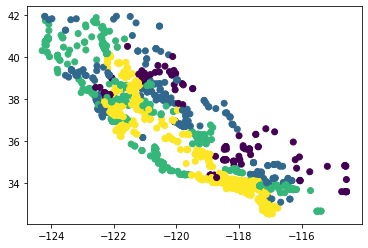

In [218]:
plt.scatter(gas_df_b['x'], gas_df_b['y'], c = gas_df_b['ordinal_cat'])

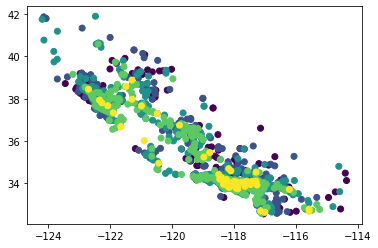

In [219]:
plt.scatter(covid_df_a['x'], covid_df_a['y'], c = covid_df_a['ordinal_cat'])

In [237]:
covid_df_a['county'].unique()

array(['Sonoma', 'Plumas', 'Nevada', 'Riverside', 'Marin', 'Kern',
       'Los Angeles', 'Calaveras', 'San Bernardino', 'Imperial', 'Lake',
       'Tulare', 'Napa', 'San Mateo', 'San Francisco', 'San Diego',
       'Ventura', 'Inyo', 'Mono', 'Fresno', 'San Luis Obispo', 'Amador',
       'Del Norte', 'Long Beach', 'Orange', 'Alameda', 'Contra Costa',
       'Siskiyou', 'Santa Clara', 'Santa Cruz', 'Yuba', 'Mendocino',
       'Butte', 'Yolo', 'Sacramento', 'El Dorado', 'Merced', 'Shasta',
       'Solano', 'Kings', 'Humboldt', 'San Joaquin', 'Stanislaus',
       'Santa Barbara', 'Sutter', 'Placer', 'Madera', 'Monterey'],
      dtype=object)

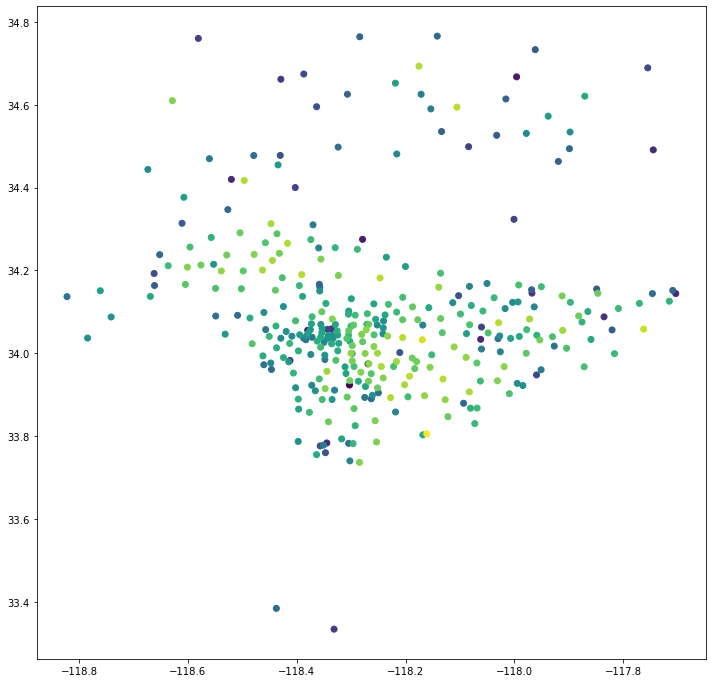

In [240]:
plt.figure(figsize = (12, 12))
df_example = covid_df_a.loc[covid_df_a['county'] == 'Los Angeles']
plt.scatter(df_example['x'], df_example['y'], c = df_example['log_cases'])

In [242]:
!pip install hdbscan

     |████████████████████████████████| 4.7 MB 2.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp38-cp38-macosx_10_9_x86_64.whl size=678986 sha256=2b9520250ed5ff783091babd7891b4f566841ef955755d1c943158ffec61b918
  Stored in directory: /Users/sophiascarano/Library/Caches/pip/wheels/eb/81/cf/9a05377f03cf1b5b057841c6ba5deac8b9926630c6bcd423e5
Successfully built hdbscan


In [243]:
import hdbscan

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [247]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [249]:
df_example.head()

,date,county,fips,place,confirmed_cases,note,x,y,log_cases,category,ordinal_cat,alpha
8,2020-03-25,Los Angeles,37.0,Athens,1,NaN,-118.303000,33.923480,0.000000,0,0,1212.881634
67,2020-10-25,Los Angeles,37.0,East Lancaster,2,NaN,-117.995982,34.667605,0.693147,0,0,136.217738
75,2020-03-25,Los Angeles,37.0,Pico,2,NaN,-118.379800,34.055700,0.693147,0,0,2205.811675
79,2020-10-25,Los Angeles,37.0,Angeles National Forest,2,NaN,-118.279007,34.275218,0.693147,0,0,453.300356
88,2020-03-16,Los Angeles,37.0,Santa Clarita and Stevenson Ranch,3,NaN,-118.520000,34.420000,1.098612,0,0,463.484220


In [252]:
data = df_example[['ordinal_cat']]
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':2})

KeyError: 0

<ipython-input-223-5609ca077c31>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_range'] = in_range


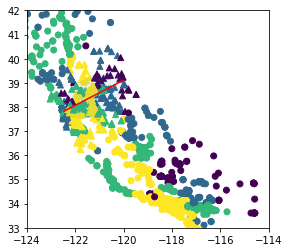

In [235]:
# let's see which gas stations we should go to if we're driving from San Fransisco to Lake Tahoe
start_point = (-122.4783, 37.8199)
end_point = (-120.0324, 39.0968)

full_viz(start = start_point, stop = end_point, max_distance_increase = 1.15, coordinate_df = gas_df_b)

In [ ]:
def start_end_line(start, end):
    slope = (start[1] - end[1]) / (start[0] - end[0])
    b = start[1] - (slope * start[0])
    
    x = np.linspace(start[0], end[0])
    y = slope * x + b
    return (x, y)

start_end_line(start_coords, end_coords)

plt.plot(start_end_line(start_coords, end_coords)[0], start_end_line(start_coords, end_coords)[1], '-r')
plt.title('Example')

x_midpoint = (start_coords[0] + end_coords[0]) / 2
y_midpoint = (start_coords[1] + end_coords[1]) / 2
midpoint = (x_midpoint, y_midpoint)
midpoint

delta_x = end_coords[0] - start_coords[0]
delta_y = end_coords[1] - start_coords[1]

d = np.sqrt((delta_x)**2 + (delta_y)**2)

max_distance_increase = 1.25
h = semi_minor_axis = d * np.sqrt(max_distance_increase**2 - 1)

line_angle = np.degrees(np.arctan(delta_y / delta_x))

# Now for the ellipse plot
# https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html
ellipse = Ellipse(xy = midpoint, width = d, height = h, angle = line_angle, alpha = .1)
plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.show()

line_angle
#print(delta_x, delta_y)

In [ ]:
def places_in_range_df(start, stop, max_distance_increase, coordinate_df):
    # assuming we have a clean df (no NaN values)
    
    # only keep x and y coordinate columns
    df = coordinate_df[['x', 'y']]
    
    # make these columns into lists
    x_list = df['x'].tolist()
    y_list = df['y'].tolist()
    
    # create list of coordinates as tuples
    coordinate_list = []
    for x in range(len(x_list)):
        a, b = x_list[x], y_list[x]
        coordinate_list.append((a, b))
    
    #create empty list that will be filled with the coordinates that are in range
    in_range = []
    #create empty list that will be filled with the trip ratio for the coordinates that are in range
    trip_ratios = []
    #create empty list that will be filled with the trip length for the coordinates that are in range
    trip_lengths = []
    
    #loop through coordinate list
    for x in coordinate_list:
        # for each row / coordiante, determine if it's in range
        if in_ellipse(start = start, end = end, target = x, max_distance_increase = max_distance_increase) == True:
            in_range.append(x)
            #trip_ratios.append(trip_ratio(start = start_coords, end = end_coords, target = x))
            #trip_length.append(trip_length(start = start_coords, end = end_coords, target = x))
        else:
            pass
        
    
    return in_range

In [85]:
df1 = df[['x', 'y']]
df1_x_list = df1['x'].tolist()
type(df1_x_list)

list

In [ ]:
# make sure the target point is within the bounded square
if x2 > x1:
    if x1 <= x_target <= x2:
        pass
    else:
        print('your target is not within the boundary')

In [ ]:
## Visualize what's above

x1 = 2
y1 = -1
x2 = 3
y2 = -3

def line_eq(x1, y1, x2, y2):
    slope = (y1 - y2) / (x1 - x2)
    b = y1 - (slope * x1)
    return (slope, b)
    
    
x_graph = np.linspace(x1, x2)
y_graph = (line_eq(x1, y1, x2, y2)[0] * x_graph) + line_eq(x1, y1, x2, y2)[1]

plt.plot(x_graph, y_graph, '-r')
plt.title('Example')